In [1]:
import pickle
import os
from traffic_equilibrium.solver import Result as FWResult
from traffic_equilibrium.graph import DiGraph
from shapely.geometry import LineString, MultiLineString
import geopandas as gpd
import pandas as pd
from shapely.geometry import shape, LineString
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as ctx
import seaborn as sns
import itertools as it
import osmnx as ox
import geopy.distance as geo_distance
import hashlib
import uuid

sns.set_context("paper")
matplotlib.style.use('./figures.mplstyle')
matplotlib.rcParams["savefig.dpi"] = 300
plt.rcParams["font.family"] = "Latin Modern Sans"
PROJECT_ROOT = '..'

In [2]:
def unpickle(fname: str):
    with open(fname, 'rb') as fp:
        return pickle.load(fp)
    
INT_SIZE = 64
BYTE_ORDER = "little"

def to_path_uuid(link_ids):
    m = hashlib.md5()
    for link_id in sorted(link_ids):
        m.update(link_id.to_bytes(INT_SIZE, BYTE_ORDER))
    return str(uuid.UUID(m.hexdigest()))
    
class FleetData:
    def __init__(self, data, prefix):
        self.data = data
        self.prefix = prefix
        
    def key(self, k):
        return '_'.join([self.prefix, k])
    
    @property
    def path_flow(self):
        return self.data[self.key('flow')]
    
    @property
    def number_of_paths(self):
        return len(self.path_flow)
    
    @property
    def link_flow(self):
        return self.link_path_incidence @ self.path_flow
    
    @property
    def usable_path_mask(self):
        return self.data[self.key('paths')]

    @property
    def usable_paths(self):
        return pd.Series(
            self.usable_path_mask,
            name=f"is_{self.prefix}_usable_path"
        )
    
    @property
    def trip_path_incidence(self):
        return self.data['trip_path']
    
    @property
    def link_path_incidence(self):
        return self.data['link_path']
    
    @property
    def trip_flow(self):
        return self.trip_path_incidence @ self.path_flow
    
    @property
    def link_path_index(self):
        lpm_coo = self.link_path_incidence.tocoo()
        return pd.DataFrame({
            'link_id': lpm_coo.row,
            'path_id': lpm_coo.col,
        }).set_index('path_id').sort_index()
    
    @property
    def trip_path_index(self):
        tpm_coo = self.trip_path_incidence.tocoo()
        return pd.DataFrame({
            'trip_id': tpm_coo.row,
            'path_id': tpm_coo.col,
        }).set_index('path_id').sort_index()
    
    @property
    def path_uuids(self):
        return self.link_path_index.groupby("path_id").link_id.apply(to_path_uuid).rename("path_uuid")
    
    def trip_path_flow(self, trip_id):
        return (
            self.trip_path_incidence[trip_id]
                .multiply(self.path_flow)
        ) 
    
    def trip_link_flow(self, trip_id):
        return (
            self.link_path_incidence
            @ self.trip_path_flow(trip_id).T
        ).toarray().squeeze()
    
    def to_path_dataframe(self):
        return (
            pd.DataFrame({
                self.prefix: self.path_flow,
                'path_id': np.arange(self.number_of_paths),
            }).set_index('path_id')
              .join(self.trip_path_index)
              .join(self.usable_paths)
              .join(self.path_uuids)
              .set_index(['path_uuid', 'trip_id'])
        )
    
    def to_link_dataframe(self):
        return pd.DataFrame({
            self.prefix: self.link_flow,
            "link_id": np.arange(len(self.link_flow))
        }).set_index('link_id')


class CriticalFleetSizeResult:
    def __init__(self, data, node_geom = None):
        self.data = data
        self.node_geom = node_geom
        self.fleet = FleetData(self.data, "fleet")
        self.user = FleetData(self.data, "user")
        self.solver_result = FWResult.load(os.path.join(PROJECT_ROOT, data['result']))
        
    @property
    def fleet_trip_fraction(self):
        return self.fleet.trip_flow / (self.fleet.trip_flow + self.user.trip_flow)
        
    @property
    def fleet_path_fraction(self):
        return self.fleet.path_flow / (self.fleet.path_flow + self.user.path_flow)
    
    @property
    def fleet_link_fraction(self):
        return self.fleet.link_flow / (self.fleet.link_flow + self.user.link_flow)
    
    @property
    def link_path_incidence(self):
        return self.data['link_path']
    
    @property
    def trip_path_incidence(self):
        return self.data['trip_path']
    
    @property
    def fleet_fraction(self):
        return self.fleet.path_flow.sum() / (self.fleet.path_flow + self.user.path_flow).sum()
    
    @property
    def link_path_index(self):
        lpm_coo = self.link_path_incidence.tocoo()
        return pd.DataFrame({
            'link_id': lpm_coo.row,
            'path_id': lpm_coo.col,
        }).set_index("path_id")
    
    @property
    def trip_path_index(self):
        tpm_coo = self.trip_path_incidence.tocoo()
        return pd.DataFrame({
            'trip_id': tpm_coo.row,
            'path_id': tpm_coo.col,
        }).set_index('path_id').sort_index()
    
    def to_link_cost_dataframe(self):
        return pd.DataFrame({
            "link_cost": self.data["link_cost"],
            "link_marginal_cost": self.data["link_marginal_cost"],
            "link_fleet_marginal_cost": self.data["link_cost"] + np.multiply(self.fleet.link_flow, self.data["link_cost_gradient"]),
            "link_cost_gradient": self.data.get("link_cost_gradient", np.NaN),
            "link_id": np.arange(len(self.data["link_cost"])),
        }).set_index("link_id")
    
    def to_path_cost_dataframe(self):
        _lc = self.to_link_cost_dataframe()
        return (
            self.to_trip_path_link_index()
                .reset_index()
                .set_index("link_id")
                .join(_lc)
                .groupby(["trip_id", "path_uuid"])
                .sum()
                .reset_index("trip_id")
        )
    
    @property
    def path_uuids(self):
        return self.link_path_index.groupby("path_id").link_id.apply(to_path_uuid).rename("path_uuid")
    
    def to_trip_info_dataframe(self):
        trips = pd.DataFrame(
            self.solver_result.problem.demand.to_trip_tuples(),
            columns=['trip_id', 'source_id', 'target_id', 'volume']
        ).set_index('trip_id')
        return trips
        
    
    def to_trip_path_link_index(self):
        return (
            self.trip_path_index
                .join(self.link_path_index)
                .join(self.path_uuids)
                .set_index(["trip_id", "path_uuid"])
        )
    
    def to_path_geodataframe(self):
        link_geom = self.to_link_geodataframe()[['geometry']]
        path_geom = (
            self.link_path_index
                .join(self.path_uuids)
                .set_index('link_id')
                .join(link_geom)
                .set_index('path_uuid')
        )
        return gpd.GeoDataFrame(path_geom).dissolve(by='path_uuid')
    
    def to_path_dataframe(self):
        return (self.to_path_geodataframe()
                    .join(self.fleet.to_path_dataframe())
                    .join(self.user.to_path_dataframe())
                    .join(self.to_path_cost_dataframe())
               )
    
    def to_link_dataframe(self):
        return (self.to_link_geodataframe()
                    .join(self.fleet.to_link_dataframe())
                    .join(self.user.to_link_dataframe())
                    .join(self.to_link_cost_dataframe())
               )
    
    def to_link_geodataframe(self):
        net = self.solver_result.problem.network
        ldf = (pd.DataFrame
                 .from_dict(net.link_info,
                            orient='index')
              )
        ldf.index = ldf.index.map(int).rename('link_id')
        if "geometry" in ldf.columns:
            ldf['geometry'] = ldf.geometry.apply(shape)
            ldf = gpd.GeoDataFrame(ldf).set_geometry("geometry").set_crs(epsg=6565)
        else:
            ldf["geometry"] = ldf.reset_index().merge(
                self.node_geom[["Node", "geometry"]].rename(columns={"geometry": "from_pt"}),
                left_on="from_node",
                right_on="Node",
            ).merge(
                self.node_geom[["Node", "geometry"]].rename(columns={"geometry": "to_pt"}),
                left_on="to_node",
                right_on="Node",
            ).set_index("link_id").apply(lambda row: LineString([row.from_pt, row.to_pt]), axis=1)
            ldf = gpd.GeoDataFrame(ldf).set_geometry("geometry").set_crs(self.node_geom.crs)
        link_nodes = pd.DataFrame(net.links(), columns=['from_node_id', 'to_node_id'])
        link_nodes.index.name = 'link_id'
        return ldf.join(link_nodes)
    
    
    @property
    def link_flow(self):
        return self.fleet.link_flow + self.user.link_flow
    

class Result:
    kinds = ('mcr', 'lp', 'mip')
    
    def __init__(self, prefix, node_geom=None):
        for kind in self.kinds:
            try:
                data = CriticalFleetSizeResult(unpickle(f"{prefix}.{kind}.pkl"), node_geom)
            except FileNotFoundError:
                data = None
            setattr(self, kind, data)
            
    def _to_path_dataframe(self):
        value_vars = ['fleet', 'user']
        dfs = []
        new_index = 'solution_concept'
        for kind in self.kinds:
            result = getattr(self, kind)
            if result is not None:
                df = result.to_path_dataframe()
                df['aggregate_flow'] = df[value_vars].sum(axis=1)
                df[new_index] = kind
                df.set_index(new_index, append=True, inplace=True)
                dfs.append(df)
        df = pd.concat(dfs)
        id_vars = list(set(df.columns) - set(value_vars))
        df = (df.melt(ignore_index=False,
                      id_vars=id_vars, value_vars=value_vars,
                      var_name='flow_class', value_name='flow')
                .set_index('flow_class', append=True)
                .sort_index()
             )
        return df
        
    def to_path_dataframe(self):
        return self._to_path_dataframe().join(self.path_impact())
    
    def to_link_dataframe(self):
        value_vars = ['fleet', 'user']
        dfs = []
        new_index = 'solution_concept'
        for kind in self.kinds:
            result = getattr(self, kind)
            if result is not None:
                df = result.to_link_dataframe()
                df['aggregate_flow'] = df[value_vars].sum(axis=1)
                df[new_index] = kind
                df.set_index(new_index, append=True, inplace=True)
                dfs.append(df)
        df = pd.concat(dfs)
        id_vars = list(set(df.columns) - set(value_vars))
        df = (df.melt(ignore_index=False,
                      id_vars=id_vars,
                      value_vars=value_vars,
                      var_name='flow_class', value_name='flow')
                .set_index('flow_class', append=True)
                .sort_index()
             )
        return df
    
    @property
    def link_path_index(self):
        dfs = []
        for kind in self.kinds:
            result = getattr(self, kind)
            if result is not None:
                dfs.append(result.to_trip_path_link_index())
        return pd.concat(dfs).reset_index().drop_duplicates().set_index(["trip_id", "path_uuid"])

    def path_impact(self):
        is_fleet_usable = self._to_path_dataframe().groupby("path_uuid").is_fleet_usable_path.first()
        n_fleet_usable = is_fleet_usable.sum()
        link_path = self.link_path_index.join(is_fleet_usable).reset_index().set_index(["link_id"])
        link_grad = (self.mcr or self.lp).to_link_cost_dataframe().link_cost_gradient
        def _compute_impact(link_ids):
	        return sum(link_grad.loc[lid] * (n_fleet_usable - link_path.loc[lid].is_fleet_usable_path.sum()) for lid in link_ids)
        path_links = link_path.reset_index().groupby("path_uuid").link_id.apply(set)
        return path_links.apply(_compute_impact).rename("path_impact")


def plot_with_basemap(gdf, *args, buffer=0, shift=0, size=20, extent=None, source=ctx.providers.CartoDB.Positron, copy=True, **kwargs):
    #if extent is not None:
    #    gdf = gdf[gdf.intersects(extent)].copy()
    if copy:
        gdf = gdf.copy()
    if extent is not None:
        xmin, ymin, xmax, ymax = extent.bounds
    else:
        xmin, ymin, xmax, ymax = gdf.unary_union.buffer(buffer).bounds
    aspect = (xmax-xmin) / (ymax-ymin)
    fig, ax = plt.subplots(figsize=(size, aspect*size))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    if args:
        cax.set_title(args[0])
    shift_geometry(gdf, shift).plot(*args, ax=ax, cax=cax, **kwargs)
    ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax])
    ctx.add_basemap(ax, crs=gdf.crs, source=source)
    ax.axis('off')
    return ax


def with_flow_stats(link_flow_df):
    link_flow_df["V/C"] = link_flow_df.flow / link_flow_df.capacity
    link_flow_df["Aggregate V/C"] = link_flow_df.aggregate_flow / link_flow_df.capacity
    link_flow_df["link_flow_fraction"] = link_flow_df.flow / link_flow_df.aggregate_flow
    return link_flow_df

def with_path_stats(path_flow_df):
    path_flow_df['is_used'] = (path_flow_df.flow > 0)
    path_flow_df['flow_fraction'] = path_flow_df.flow / path_flow_df.aggregate_flow
    path_flow_df['is_exclusive'] = path_flow_df.flow_fraction >= 0.95
    return path_flow_df

def shift_geometry(link_flow_df, shift):
    if shift:
        link_flow_df['geometry'] = link_flow_df.geometry.apply(LineShifter(shift))
    return link_flow_df


class LineShifter:
    def __init__(self, alpha):
        self.alpha = alpha
        
    def __call__(self, line):
        fn = {
            'LineString': self._line_shift,
            'MultiLineString': self._multi_line_shift
        }.get(line.type)
        if fn is None:
            raise Exception(f"Cannot shift geometry of type {line.type}")
        else:
            return fn(line)
        
    def _multi_line_shift(self, multi_line):
        return MultiLineString([
            self._line_shift(line)
            for line in multi_line
        ])
    
    def _line_shift(self, line):
        coords = iter(line.coords)
        x0, y0 = next(coords)
        shifted_coords = [(x0, y0)]
        for x1, y1 in coords:
            shifted_coords.pop()
            shifted_coords.extend(shift_line_segment_coords(
                x0, y0, x1, y1, self.alpha
            ))
            x0, y0 = x1, y1
        return LineString(shifted_coords)

def safe_div(a, b):
    if b == 0:
        return 0.0
    else:
        return a / b

def shift_line_segment_coords(x0, y0, x1, y1, alpha):
    dx = (x1 - x0)
    dy = (y1 - y0)
    z = (dx**2 + dy**2)**0.5
    return [
        (x0 - alpha * safe_div(dy, z), y0 + alpha * safe_div(dx, z)),
        (x1 - alpha * safe_div(dy, z), y1 + alpha * safe_div(dx, z))
    ]

def zoom_to(ax, center_pt=None, level=1):
    xmin, xmax = ax.get_xlim()
    dx = (xmax - xmin) / level
    ymin, ymax = ax.get_ylim()
    dy = (ymax - ymin) / level
    if center_pt is None:
        x, y = (xmax-xmin)/2.0, (ymax-ymin)/2.0
    else:
        x, y = center_pt
        assert xmin <= x <= xmax
        assert ymin <= y <= ymax
    ax.set_xlim([x - dx, x + dx])
    ax.set_ylim([y - dy, y + dy])
    return ax

def add_demand_level_index(df, demand_level):
    df["demand_level"] = demand_level
    return df.set_index("demand_level", append=True)

def place_to_extent(place, crs, buffer_dist=0):
    return ox.geocode_to_gdf(place, buffer_dist=buffer_dist).to_crs(crs).unary_union

def select(df, **kwargs):
    keys, values = zip(*kwargs.items())
    return df.xs(
        values,
        level=keys,
        drop_level=False
    )

def flatten_columns(df):
    df.columns = ['_'.join(filter(None, col)) for col in df.columns.values]
    return df

def map_style():
    return matplotlib.style.context("./maps.mplstyle")

def set_linestyles(g, linestyles):
    axes = list(g.axes_dict.values())or [g.ax]
    for ax in axes:
        legend = ax.legend_ or g.legend
        handles = [None]*len(linestyles) if legend is None else legend.legendHandles
        for lines, linestyle, legend_handle in zip(ax.lines[::-1], linestyles, handles):
            lines.set_linestyle(linestyle)
            if legend_handle is not None:
                legend_handle.set_linestyle(linestyle)

In [3]:
sf_nodes = pd.read_csv(
    "../test/fixtures/TransportationNetworks/SiouxFalls/SiouxFalls_node.tntp",
    sep="\t",
    usecols=["Node", "X", "Y"]
)
sf_nodes = gpd.GeoDataFrame(
    sf_nodes,
    geometry=gpd.points_from_xy(sf_nodes.X, sf_nodes.Y),
    crs=4326,
)

In [32]:
k0 = Result("../sioux-falls-scale-1.0-k0", sf_nodes)
k1 = Result("../sioux-falls-scale-1.0-k1", sf_nodes)
k2 = Result("../sioux-falls-scale-1.0-k2", sf_nodes)
path_flows = pd.concat([
    k0.to_path_dataframe(),
    k1.to_path_dataframe(),
    k2.to_path_dataframe(),
], keys=[0, 1, 2], names=["k"]).drop(columns=["trip_id"])

In [33]:
total_flow = path_flows.groupby(["k", "solution_concept", "flow_class"])[["flow", "aggregate_flow"]].sum()

In [34]:
path_flows = path_flows.join(path_flows.groupby(["k", "solution_concept", "flow_class", "trip_id"]).aggregate_flow.sum().rename("trip_demand"))
path_flows["choice_fraction"] = (path_flows.flow / path_flows.trip_demand).rename("path_choice_fraction")

In [35]:
path_flows.choice_fraction

k  trip_id  solution_concept  flow_class  path_uuid                           
0  0        lp                fleet       3b5d3c7d-207e-37dc-eeed-d301e35e2e58    0.0
                              user        3b5d3c7d-207e-37dc-eeed-d301e35e2e58    1.0
            mcr               fleet       3b5d3c7d-207e-37dc-eeed-d301e35e2e58    0.0
                              user        3b5d3c7d-207e-37dc-eeed-d301e35e2e58    1.0
   1        lp                fleet       bc5481e1-24c0-0f21-e314-ef579dc23c42    0.0
                                                                                 ... 
2  526      mcr               user        a1ac973a-1d9b-92a4-2e45-aa29a93bbf0d    0.0
   527      lp                fleet       7590f271-5c78-e353-0d3e-a1c2e0e0b784    0.0
                              user        7590f271-5c78-e353-0d3e-a1c2e0e0b784    1.0
            mcr               fleet       7590f271-5c78-e353-0d3e-a1c2e0e0b784    0.0
                              user        7590f271-5c78-e353-

[Text(0, 0.5, 'fleet fraction')]

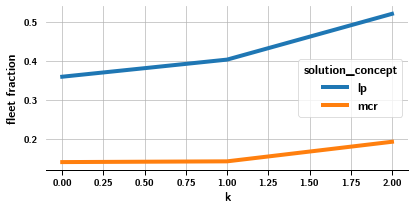

In [7]:
ax = (total_flow.flow / total_flow.aggregate_flow).xs("fleet", level="flow_class").rename("fleet_fraction").reset_index().pivot(index="k", columns="solution_concept", values="fleet_fraction").plot()
ax.set(ylabel="fleet fraction")

In [8]:
(total_flow.flow / total_flow.aggregate_flow).xs("fleet", level="flow_class").rename("fleet_fraction").reset_index().pivot(index="k", columns="solution_concept", values="fleet_fraction") * 100

solution_concept,lp,mcr
k,,
0,35.957634,14.126369
1,40.335416,14.316105
2,52.039536,19.320522


In [9]:
total_cost = (path_flows.flow * path_flows.link_cost).rename("total_cost").groupby(["k", "solution_concept", "flow_class"]).sum()
average_cost = (total_cost / total_flow.flow).rename("average_cost")

In [10]:
average_cost.xs("fleet", level="flow_class").reset_index().pivot(index="k", columns="solution_concept", values="average_cost")

solution_concept,lp,mcr
k,,
0,27.439404,32.377793
1,22.140558,29.528453
2,19.099487,28.027273


[Text(0, 0.5, 'average cost')]

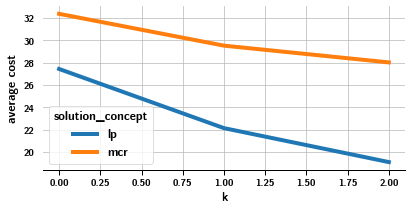

In [11]:
ax = average_cost.xs("fleet", level="flow_class").reset_index().pivot(index="k", columns="solution_concept", values="average_cost").plot()
ax.set(ylabel="average cost")

In [12]:
def exp_loglikelihood(path_flows, lambda_, eps=1e-2):
    least_cost = (path_flows.groupby(["k", "solution_concept", "trip_id"])
                            .link_cost.min()
                            .rename("least_cost")
                 )
    total_flow = (path_flows.groupby(["k", "solution_concept", "flow_class"])
                            .aggregate_flow
                            .sum()
                            .rename("total_flow")
                  )
    _df = path_flows.join(least_cost)
    excess_cost = (_df.link_cost*(1+eps) - _df.least_cost).clip(0, None)
    return np.log(lambda_) * total_flow - lambda_ * (_df.flow * excess_cost).groupby(["k", "solution_concept", "flow_class"]).sum()

def norm_loglikelihood(path_flows, rho, eps=1e-2):
    least_cost = (path_flows.groupby(["k", "solution_concept", "trip_id"])
                            .link_cost.min()
                            .rename("least_cost")
                 )
    total_flow = (path_flows.groupby(["k", "solution_concept", "flow_class"])
                            .aggregate_flow
                            .sum()
                            .rename("total_flow")
                  )
    _df = path_flows.join(least_cost)
    excess_cost = (_df.link_cost*(1+eps) - _df.least_cost).clip(0, None)
    return 0.5 * np.log(2 * rho**2 / np.pi) * total_flow - 0.5 * rho**2 *  (_df.flow * (excess_cost**2)).groupby(["k", "solution_concept", "flow_class"]).sum()

In [13]:
lambdas = np.linspace(1e-12, 2, num=100)
eps = 1e-2
likelihoods = pd.concat([
    pd.concat(
        [exp_loglikelihood(path_flows, l, eps) for l in lambdas],
        keys=lambdas,
        names=["lambda"]
    ),
    pd.concat(
        [norm_loglikelihood(path_flows, l, eps) for l in lambdas],
        keys=lambdas,
        names=["lambda"]
    )],
    keys=["exp", "norm"],
    names=["model"]
).rename("log_likelihood")

In [14]:
ll_ratio = (likelihoods.xs("lp", level="solution_concept") - likelihoods.xs("mcr", level="solution_concept")).rename("log_likelihood_ratio")

In [36]:
def exp_loglikelihood_choice(path_flows, lambda_, eps=1e-2):
    least_cost = (path_flows.groupby(["k", "solution_concept", "trip_id"])
                            .link_cost.min()
                            .rename("least_cost")
                 )
    n_trips = (path_flows.groupby(["k", "solution_concept", "flow_class", "trip_id"])
                            .size()
                            .groupby(["k", "solution_concept", "flow_class"])
                            .count()
                            .rename("n_trips")
                  )
    _df = path_flows.join(least_cost)
    excess_cost = (_df.link_cost*(1+eps) - _df.least_cost).clip(0, None)
    return np.log(lambda_) * n_trips - lambda_ * (_df.choice_fraction * excess_cost).groupby(["k", "solution_concept", "flow_class"]).sum()

def norm_loglikelihood_choice(path_flows, lambda_, eps=1e-2):
    least_cost = (path_flows.groupby(["k", "solution_concept", "trip_id"])
                            .link_cost.min()
                            .rename("least_cost")
                 )
    n_trips = (path_flows.groupby(["k", "solution_concept", "flow_class", "trip_id"])
                            .size()
                            .groupby(["k", "solution_concept", "flow_class"])
                            .count()
                            .rename("n_trips")
                  )
    _df = path_flows.join(least_cost)
    excess_cost = (_df.link_cost*(1+eps) - _df.least_cost).clip(0, None)
    return 0.5 * np.log(2 * rho**2 / np.pi) * n_trips - 0.5 * rho**2 *  (_df.choice_fraction * (excess_cost**2)).groupby(["k", "solution_concept", "flow_class"]).sum()

In [51]:
lambdas = np.linspace(1e-12, 1, num=100)
eps = 0
likelihoods_choice = pd.concat([
    pd.concat(
        [exp_loglikelihood(path_flows, l, eps) for l in lambdas],
        keys=lambdas,
        names=["lambda"]
    ),
    pd.concat(
        [norm_loglikelihood(path_flows, l, eps) for l in lambdas],
        keys=lambdas,
        names=["lambda"]
    )],
    keys=["exp", "norm"],
    names=["model"]
).rename("log_likelihood")

In [52]:
ll_choice_ratio = (likelihoods_choice.xs("lp", level="solution_concept") - likelihoods_choice.xs("mcr", level="solution_concept")).rename("log_likelihood_ratio")

In [53]:
ll = exp_loglikelihood_choice(path_flows, 2, 0).xs("fleet", level="flow_class")
(ll.xs("lp", level="solution_concept") - ll.xs("mcr", level="solution_concept"))

k
0    1.266529e+02
1    2.784513e+00
2    8.390089e-11
dtype: float64

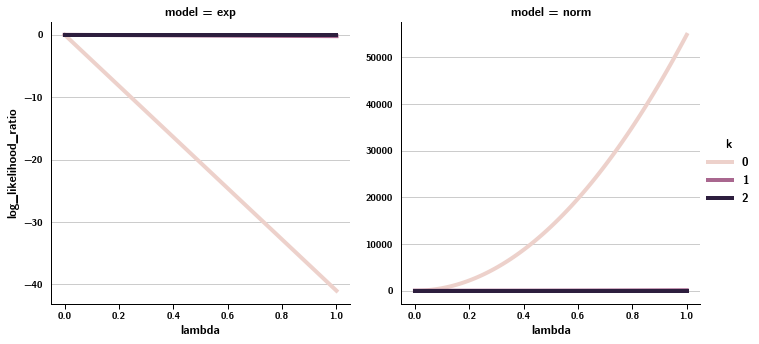

In [55]:
sns.relplot(
    data=ll_choice_ratio.xs("fleet", level="flow_class").reset_index(),
    x="lambda",
    y="log_likelihood_ratio",
    hue="k",
    col="model",
    kind="line",
    facet_kws=dict(sharey=False),
)

In [ ]:
sns.relplot(
    data=likelihoods.xs("fleet", level="flow_class").reset_index(),
    x="lambda",
    y="log_likelihood",
    hue="k",
    col="solution_concept",
    row="model",
    kind="line",
    facet_kws=dict(sharey="row")
)